In [1]:
import numpy as np
import matplotlib.pyplot as plt
#scipy cwt
import scipy
import sys
import os
from ssqueezepy import ssq_cwt

from utils import *

Wavelib path: /Users/sam/Repositories/ethz/bearings-max78000/firmware/synthed_net/bearingnet/cwt_verification/../../../../../wavelib/python/ 


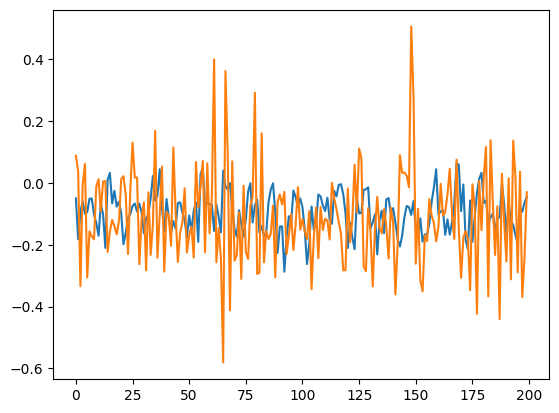

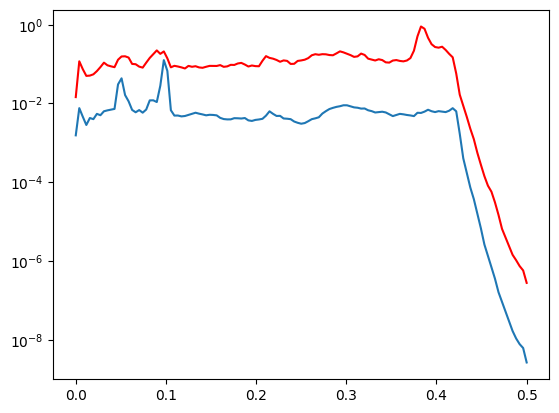

In [2]:
all_normal_signal = np.loadtxt('exp1_b3_ch5_first100k.txt')
all_fault_signal = np.loadtxt('exp1_b3_ch5_last100k.txt')

#first decimate the signals by 2
all_normal_signal = scipy.signal.decimate(all_normal_signal, DECIMATION)
all_fault_signal = scipy.signal.decimate(all_fault_signal, DECIMATION)

#all_normal_signal = np.round(all_normal_signal*2**2)
#all_fault_signal = np.round(all_fault_signal*2**2)

smooth_all_normal_signal = exponential_smoothing(all_normal_signal, 1) #1 means no smoothing --> this yields best results
smooth_all_fault_signal = exponential_smoothing(all_fault_signal, 1)


#extract windows of 200 samples from the smoothed signals
normal_signals = []
fault_signals = []
for i in range(0, len(smooth_all_normal_signal)-SAMPLE_LEN, SAMPLE_LEN):
    normal_signals.append(smooth_all_normal_signal[i:i+SAMPLE_LEN])
    fault_signals.append(smooth_all_fault_signal[i:i+SAMPLE_LEN])


#mean_normal_signal = np.mean(np.array(normal_signals),axis=0)
#mean_fault_signal = np.mean(np.array(fault_signals),axis=0)


mean_fault_signal = np.array(fault_signals[2])
mean_normal_signal = np.array(normal_signals[9])


#standardise the signals
#mean_normal_signal = (mean_normal_signal - np.mean(mean_normal_signal))/np.std(mean_normal_signal)
#mean_fault_signal = (mean_fault_signal - np.mean(mean_fault_signal))/np.std(mean_fault_signal)

plt.plot(mean_normal_signal)
plt.plot(mean_fault_signal)

plt.figure()
#plot psd of the mean signals
f, Pxx_den = scipy.signal.welch(smooth_all_normal_signal, fs=1)
plt.semilogy(f, Pxx_den)
f, Pxx_den = scipy.signal.welch(smooth_all_fault_signal, fs=1)
plt.semilogy(f, Pxx_den, 'r')

### Copy to micro

In [ ]:
# for C header file
cstring = "//generated by python script\n //params: INTERP_SIZE=%d, SCALES=%d, MORLET=%d, SAMPLE_LEN=%d\n" % (INTERP_SIZE, SCALES, MORLET, SAMPLE_LEN)
# prolog
cstring += ('double mean_normal_signal[%d] = {' % (int(SAMPLE_LEN)))
for element in mean_normal_signal:
    cstring += ('%f,' % float(element))
# epilog
cstring += ('};\n')

cstring += ('double mean_fault_signal[%d] = {' % (int(SAMPLE_LEN)))
for element in mean_fault_signal:
    cstring += ('%f,' % float(element))
# epilog
cstring += ('};')

#copy to clipboard
import pyperclip
pyperclip.copy(cstring)

compare scipy output with: https://rafat.github.io/wavelib/#/cdisplay

In [ ]:
def plot_cwts(signal, wavelib=False, normal=True):    
    VMIN = 0
    VMAX = 0.4
    BINS = 100
    
    morlet_mu = MORLET
    dt=1
    wavelib_scales = np.array([2.000000, 2.804027, 3.931282, 5.511710, 7.727491, 10.834045, 15.189475, 21.295845, 29.857058, 41.859991, 58.688264, 82.281725,]) #wavelib generates this for us, we extracted it from the microcontroller
    wavelib_dj = 0.487500 #Separation between scales. eg., scale = s0 * 2 ^ ( [0:N-1] *dj ) or scale = s0 *[0:N-1] * dj
    wavelib_J = SCALES #scales
    
    ssqcwt_scales = np.exp(np.linspace(np.log(wavelib_scales)[0], np.log(wavelib_scales)[-1], SCALES)) #= log(wavelib_scales)

    wavelib_as_mag = wavelib_as.cwt(signal, morlet_mu, dt, wavelib_J)
    

    scipy_cwt = scipy.signal.cwt(signal, scipy.signal.morlet2,widths=wavelib_scales, w=morlet_mu)
    scipy_cwt = np.abs(scipy_cwt)

    if wavelib:
        if normal:
            wavelib_cwt = np.loadtxt("cwt_output_bearings_avg_normal.txt")
        else:
            wavelib_cwt = np.loadtxt("cwt_output_bearings_avg_fault.txt")
        
        wavelib_cwt = wavelib_cwt.reshape((wavelib_J,SAMPLE_LEN))
        


    t, w, *_= ssq_cwt(signal, ('morlet', {'mu': morlet_mu}), scales = ssqcwt_scales)
    w = np.abs(w)

    ################################################################################################################
    #                                                  plot CWT 
    ################################################################################################################
    #make a subplot, scipy on left, rafat.github.io/wavelib on right (with titles)
    plt.figure(figsize=(25, 5))
    plt.subplot(1, 4, 1)
    plt.title('scipy cwt')
    plt.imshow(scipy_cwt, aspect='auto', cmap='turbo', vmin=VMIN, vmax=VMAX)

    #ssq cwt
    plt.subplot(1, 4, 2)
    plt.title('ssqueezepy cwt')
    plt.imshow(w, aspect='auto', cmap='turbo', vmin=VMIN, vmax=VMAX)
    

    if wavelib:

        plt.subplot(1, 4, 3)
        plt.title('rafat.github.io/wavelib cwt on ARM Cortex M4\n+ bilinear interp')
        print(wavelib_cwt.shape)
        wavelib_cwt = wavelib_cwt.flatten()
        wavelib_cwt = wavelib_as.bilinear_interpolate(wavelib_cwt, SCALES, SAMPLE_LEN, INTERP_SIZE, INTERP_SIZE)
        plt.imshow(wavelib_cwt, cmap='turbo', vmin=VMIN, vmax=VMAX,interpolation='none')
        
        
        plt.subplot(1, 4, 4)
        plt.title('rafat.github.io/wavelib cwt on Apple Silicon\n+ bilinear interp')
        
        
        wavelib_as_mag = wavelib_as_mag.flatten()
        wavelib_as_mag = wavelib_as.bilinear_interpolate(wavelib_as_mag, SCALES, SAMPLE_LEN, INTERP_SIZE, INTERP_SIZE)
        print(np.max(wavelib_as_mag), np.std(wavelib_as_mag) , np.min(wavelib_as_mag))

    
        plt.imshow(wavelib_as_mag, cmap='turbo', vmin=VMIN, vmax=VMAX,interpolation='none') #, interpolation='bilinear', aspect='auto'$
        
        #y axis is 0 = nyquist frequency, >8 small freqs
        #x axis is time


    ################################################################################################################
    #                                             plot histograms
    ################################################################################################################
    plt.figure(figsize=(25, 5))
    plt.subplot(1, 4, 1)
    plt.title('scipy cwt')
    plt.hist(scipy_cwt.flatten(), bins=BINS)
    plt.xlim([VMIN, VMAX])

    plt.subplot(1, 4, 2)
    plt.title('ssqueezepy cwt')
    plt.hist(w.flatten(), bins=BINS)
    plt.xlim([VMIN, VMAX])
    
        

    if wavelib:
        plt.subplot(1, 4, 3)
        plt.title('rafat.github.io/wavelib cwt on ARM Cortex M4')
        plt.hist(wavelib_cwt.flatten(), bins=BINS)
        #x axis limit
        plt.xlim([VMIN, VMAX])
        
        plt.subplot(1, 4, 4)
        plt.title('rafat.github.io/wavelib cwt on Apple Silicon')
        plt.hist(wavelib_as_mag.flatten(), bins=BINS)
        #x axis limit
        plt.xlim([VMIN, VMAX])

plot_cwts(mean_normal_signal, wavelib=True, normal=True)
print("-----")
plot_cwts(mean_fault_signal, wavelib=True, normal=False)

In [ ]:
#Somehow there is a bug  in interpolation when running on the device, see below

In [3]:
wavelib_cwt_bilinear = np.loadtxt("cwt_output_bearings_avg_normal_bilinear.txt")
wavelib_cwt_bilinear_fault = np.loadtxt("cwt_output_bearings_avg_fault_bilinear.txt")

wavelib_cwt_bilinear = wavelib_cwt_bilinear.reshape((INTERP_SIZE,INTERP_SIZE))
wavelib_cwt_bilinear_fault = wavelib_cwt_bilinear_fault.reshape((INTERP_SIZE,INTERP_SIZE))

#histogram of the bilinear interpolated cwt
plt.figure()
plt.hist(wavelib_cwt_bilinear.flatten(), bins=100)
plt.xlim([0, 0.7])
plt.title('histogram of the bilinear interpolated cwt')

#plt imshow
plt.figure()
plt.imshow(wavelib_cwt_bilinear, cmap='turbo', vmin=0, vmax=0.7,interpolation='none')

#histogram of the bilinear interpolated cwt fault
plt.figure()
plt.hist(wavelib_cwt_bilinear_fault.flatten(), bins=100)
plt.xlim([0, 0.7])
plt.title('histogram of the bilinear interpolated cwt fault')

#plt imshow
plt.figure()
plt.imshow(wavelib_cwt_bilinear_fault, cmap='turbo', vmin=0, vmax=0.7,interpolation='none')


ValueError: cannot reshape array of size 2304 into shape (50,50)

(50, 50)


(0.0, 1.1111111111111112)

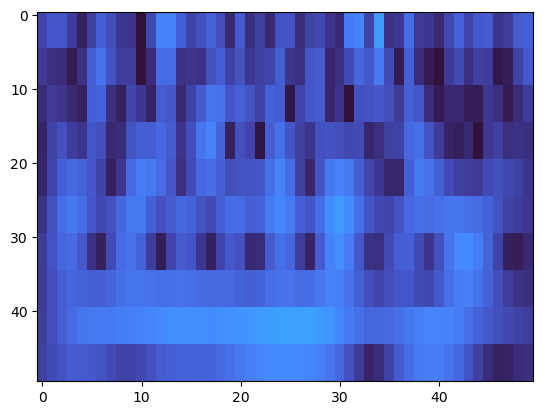

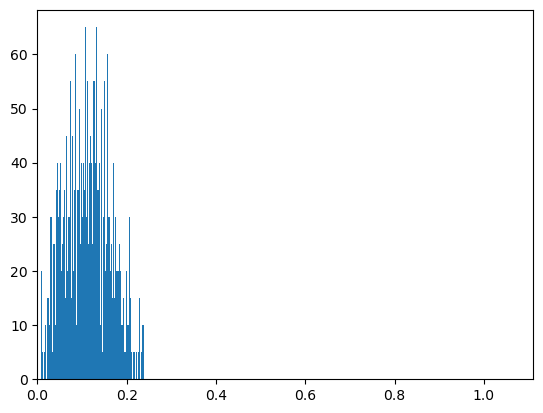

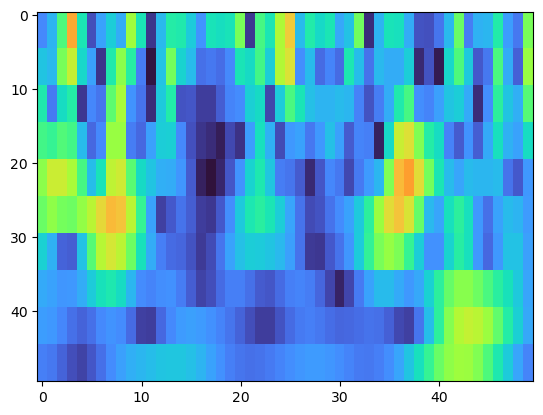

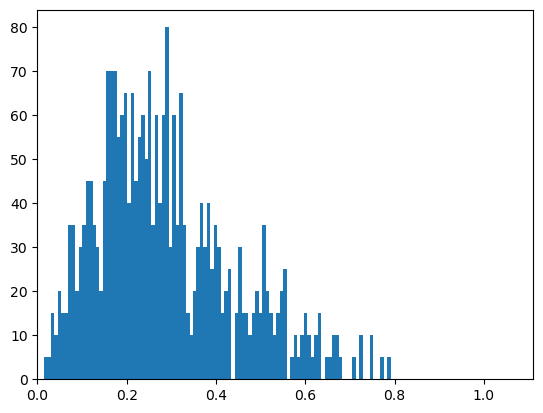

In [2]:
all_normal_signal = np.loadtxt('exp1_b3_ch5_first100k.txt')
all_fault_signal = np.loadtxt('exp1_b3_ch5_last100k.txt')


#decimate by 2 first --> per file now 20480/2
all_normal_signal = all_normal_signal[::2]
all_fault_signal = all_fault_signal[::2]

#extract 50 windows à 192 samples each
N = SAMPLE_LEN
morlet_mu = MORLET
wavelib_J = SCALES
dt=DT
NWindows=50
linear_scale_type = 0
s0=S0
dj=DJ
power=POW
REFERENCE_VALUE = REFERENCE

normal_windows = []
fault_windows = []
start = 20
for i in range(start,start+NWindows):
    normal_windows.append(all_normal_signal[i*N:(N+i*N)])
    fault_windows.append(all_fault_signal[i*N:(N+i*N)])

#create an average of those 50 windows
normal_windows_avg = np.mean(np.array(normal_windows), axis=0)
fault_windows_avg =  np.mean(np.array(fault_windows), axis=0)

assert fault_windows_avg.shape[0] == N
assert normal_windows_avg.shape[0] == N

normal_img = get_image(normal_windows_avg)
fault_img = get_image(fault_windows_avg)

print(normal_img.shape)

#compare the 2 average windows using the same color scale
plt.figure()
plt.imshow(normal_img, aspect='auto', cmap="turbo", vmax=0.1/REFERENCE)
plt.figure()
plt.hist(normal_img.flatten(), bins=100)
plt.xlim([0, 0.1/REFERENCE])


plt.figure()
plt.imshow(fault_img, aspect='auto', cmap="turbo", vmax=0.1/REFERENCE)
plt.figure()
plt.hist(fault_img.flatten(), bins=100)
plt.xlim([0, 0.1/REFERENCE])

In [16]:
first_normal = '''0.378009 0.442320 0.467206 0.459620 0.432369 0.389222 0.333255 0.289444 0.298783 0.358164 0.426223 0.483019 0.533499 0.577029 0.591591 0.556532 0.478541 0.392122 0.337628 0.330144 0.354800 0.395170 0.442498 0.486823 0.514464 0.516582 0.498726 0.479637 0.478313 0.497794 0.519512 0.517326 0.477899 0.410472 0.345083 0.325915 0.391129 0.540914 0.742672 0.947151 1.102763 1.176324 1.168321 1.111565 1.051718 1.021194 1.025607 1.049397 1.069281 1.065356 1.027617 0.959053 0.875993 0.804963 0.774981 0.800526 0.862822 0.917739 0.924505 0.865746 0.750004 0.601981 0.450625 0.324002 0.249948 0.241025 0.271404 0.308486 0.337499 0.360786 0.392283 0.438096 0.485280 0.518153 0.533306 0.536324 0.532433 0.524760 0.518736 0.521898 0.536185 0.553685 0.561165 0.545359 0.499998 0.435961 0.379280 0.348617 0.339406 0.340055 0.350088 0.376644 0.420082 0.471803 0.525298 0.578458 0.626739 0.664072 0.692228 0.723417 0.770034 0.833555 0.904626 0.968981 1.010357 1.011999 0.961307 0.856524 0.710925 0.551804 0.413211 0.320928 0.286708 0.338818 0.491314 0.697447 0.897164 1.045130 1.119223 1.123382 1.081496 1.021476 0.958948 0.892727 0.812852 0.711556 0.588567 0.449094 0.300737 0.159523 0.092486 0.151126 0.200394 0.209022 0.194333 0.187566 0.209782 0.257470 0.311556 0.349389 0.356800 0.337639 0.314032 0.315397 0.354443 0.413510 0.460601 0.468080 0.425141 0.345420 0.265112 0.225771 0.238814 0.288779 0.369146 0.466136 0.543012 0.558796 0.496304 0.374212 0.237858 0.149001 0.160646 0.221379 0.286022 0.350029 0.416257 0.480028 0.525976 0.539547 0.521236 0.492829 0.490331 0.533257 0.599234 0.647629 0.650706 0.603402 0.521184 0.431687 0.362459 0.330726 0.341678 0.389163 0.455350 0.519293 0.571123 0.623260 0.706394 0.837495 0.988121 1.097295 1.111589 1.016385 0.841599 0.642561 0.470751 0.350404 0.272314 0.212412 0.282079 0.292288 0.280406 0.268878 0.283080 0.321376 0.360975 0.383759 0.381492 0.352383 0.304034 0.266951 0.291101 0.374864 0.466065 0.526188 0.541371 0.516060 0.464466 0.403305 0.349013 0.316926 0.314309 0.331762 0.351436 0.363206 0.371177 0.387727 0.418464 0.453355 0.473576 0.461755 0.406618 0.303804 0.155949 0.037565 0.238244 0.443771 0.623999 0.754699 0.818619 0.810802 0.743524 0.650663 0.585444 0.590120 0.651396 0.722762 0.770700 0.780571 0.746278 0.664544 0.538470 0.391892 0.306028 0.383518 0.544437 0.685549 0.761673 0.758385 0.682011 0.552372 0.394244 0.230520 0.081553 0.059745 0.143892 0.187123 0.190033 0.183853 0.227462 0.329703 0.449753 0.555833 0.631736 0.672780 0.681559 0.663804 0.625802 0.574518 0.519774 0.474766 0.449407 0.439666 0.428930 0.401951 0.353807 0.288672 0.214428 0.139748 0.082076 0.086424 0.136405 0.190224 0.242972 0.294805 0.337974 0.363661 0.377188 0.402764 0.463227 0.555732 0.660823 0.760001 0.837964 0.880467 0.876845 0.824576 0.729718 0.601751 0.447177 0.267762 0.075208 0.185666 0.422570 0.646902 0.826192 0.935261 0.964971 0.927850 0.854846 0.780727 0.723131 0.674287 0.616789 0.542954 0.458315 0.373034 0.293927 0.226579 0.182510 0.168325 0.163642 0.141795 0.098609 0.074864 0.122632 0.183856 0.221026 0.222541 0.189886 0.133154 0.067110 0.043479 0.108710 0.182609 0.243767 0.274957 0.261411 0.197027 0.089801 0.075555 0.227202 0.379735 0.509291 0.598030 0.631874 0.604647 0.521916 0.401165 0.269419 0.169591 0.172058 0.255008 0.352439 0.444402 0.523649 0.585320 0.627600 0.653396 0.669551 0.683326 0.698452 0.713312 0.721706 0.714995 0.684627 0.624747 0.534628 0.419979 0.292873 0.173909 0.113226 0.153830 0.210074 0.232818 0.215383 0.208058 0.316178 0.520089 0.742669 0.925407 1.029060 1.038858 0.965385 0.836952 0.686792 0.541401 0.414944 0.310574 0.168942 0.139310 0.085133 0.019340 0.074891 0.151587 0.211687 0.245073 0.246586 0.217044 0.167418 0.134416 0.172176 0.254482 0.333918 0.386487 0.401209 0.376564 0.318577 0.238155 0.148201 0.061518 0.014137 0.061751 0.082369 0.075566 0.061766 0.092326 0.160189 0.233724 0.297185 0.342929 0.370094 0.384599 0.397743 0.420785 0.456552 0.496310 0.525347 0.530206 0.502510 0.440073 0.347396 0.237497 0.141894 0.134780 0.204624 0.274343 0.324471 0.354838 0.367596 0.363023 0.343418 0.321496 0.323240 0.367253 0.440125 0.512269 0.560288 0.572998 0.550710 0.502061 0.439388 0.374109 0.313577 0.259778 0.209624 0.158206 0.110141 0.108479 0.179568 0.277303 0.372653 0.449591 0.498510 0.515506 0.501298 0.459283 0.393813 0.309942 0.215240 0.125397 0.086513 0.126814 0.173546 0.197757 0.197286 0.178582 0.150956 0.122677 0.098808 0.081023 0.069577 0.066993 0.075583 0.088053 0.090850 0.073402 0.035538 0.046829 0.121239 0.204145 0.287026 0.365931 0.436259 0.491489 0.525979 0.538970 0.535952 0.526268 0.519363 0.523165 0.544066 0.583994 0.635282 0.680475 0.698738 0.673822 0.599852 0.483996 0.346544 0.221556 0.160481 0.177105 0.205287 0.213118 0.206467 0.202838 0.212126 0.227780 0.237117 0.231903 0.210456 0.177470 0.145179 0.132075 0.144803 0.166749 0.180927 0.180939 0.168600 0.150662 0.136260 0.134268 0.148741 0.176050 0.208294 0.237802 0.260616 0.280219 0.308932 0.360353 0.435741 0.521709 0.599395 0.652610 0.672018 0.656649 0.613272 0.553988 0.492697 0.441539 0.408404 0.395938 0.401465 0.417637 0.434648 0.443880 0.441435 0.430010 0.417925 0.414603 0.424320 0.443537 0.464015 0.477088 0.475726 0.455434 0.415325 0.359081 0.294844 0.233596 0.186102 0.158069 0.146610 0.148368 0.175090 0.246030 0.360928 0.501468 0.642616 0.758681 0.828845 0.842028 0.799246 0.712508 0.600696 0.483873 0.377842 0.290678 0.194218 0.205406 0.215302 0.226627 0.241115 0.258722 0.278133 0.297908 0.317283 0.336247 0.355082 0.373648 0.390744 0.403911 0.409926 0.405823 0.390000 0.362862 0.326769 0.285341 0.242470 0.201474 0.164799 0.134572 0.114120 0.108983 0.122893 0.152575 0.191487 0.234303 0.277460 0.318679 0.356434 0.389466 0.416486 0.436199 0.447604 0.450367 0.445020 0.432806 0.415234 0.393584 0.368657 0.340861 0.310459 0.277915 0.244598 0.214236 0.194683 0.196337 0.223235 0.268531 0.321996 0.375569 0.423662 0.462219 0.488114 0.499115 0.494327 0.474845 0.444219 0.408325 0.374297 0.348425 0.333769 0.329434 0.332474 0.340459 0.352296 0.367168 0.383124 0.396743 0.404097 0.402208 0.390133 0.369185 0.342238 0.312434 0.282015 0.252119 0.223700 0.198606 0.179358 0.167111 0.159763 0.152996 0.143206 0.129199 0.111873 0.092843 0.073185 0.053312 0.035041 0.028326 0.042785 0.065647 0.088839 0.109624 0.126886 0.140366 0.150794 0.160232 0.171460 0.185786 0.201152 0.213172 0.218744 0.220077 0.226986 0.252819 0.302906 0.370105 0.441964 0.506683 0.554879 0.579943 0.578288 0.549626 0.497130 0.427217 0.348773 0.271663 0.204382 0.150842 0.107930 0.067767 0.026750 0.039095 0.093868 0.150427 0.201702 0.243280 0.272834 0.290006 0.295827 0.291814 0.279180 0.258475 0.229772 0.193127 0.148969 0.098235 0.042586 0.022722 0.084799 0.151375 0.220180 0.290480 0.361459 0.431903 0.499931 0.562783 0.616790 0.657663 0.681102 0.683607 0.663233 0.620106 0.556569 0.477030 0.387702 0.296582 0.214268 0.155933 0.136715 0.147430 0.160951 0.161139 0.143205 0.108330 0.060905 0.010051 0.052103 0.106350 0.155847 0.198555 0.232958 0.257834 0.272713 0.278624 0.278564 0.277333 0.280629 0.293658 0.319902 0.360605 0.414747 0.478939 0.547334 0.611997 0.663940 0.694660 0.697817 0.670617 0.614541 0.535197 0.441337 0.343285 0.251211 0.173705 0.253532 0.274706 0.292388 0.306566 0.317750 0.326953 0.335547 0.344947 0.356169 0.369397 0.383785 0.397597 0.408632 0.414755 0.414366 0.406732 0.392135 0.371828 0.347828 0.322572 0.298486 0.277564 0.261053 0.249345 0.242098 0.238488 0.237494 0.238125 0.239619 0.241556 0.243856 0.246599 0.249713 0.252728 0.254773 0.254877 0.252436 0.247589 0.241285 0.234892 0.229425 0.224763 0.219410 0.211017 0.197357 0.177330 0.151954 0.125907 0.110012 0.117978 0.149812 0.193569 0.239471 0.281454 0.315410 0.338327 0.348007 0.343062 0.323011 0.288431 0.241151 0.184652 0.125724 0.082949 0.094426 0.145643 0.202551 0.253533 0.294049 0.321831 0.335894 0.336301 0.324106 0.301381 0.271258 0.237989 0.206877 0.183635 0.172315 0.172490 0.179329 0.187012 0.191319 0.190111 0.182925 0.170523 0.154554 0.137292 0.121355 0.109263 0.102691 0.101756 0.105103 0.110764 0.116818 0.121488 0.123105 0.120243 0.112057 0.098720 0.081873 0.065080 0.053679 0.051125 0.053582 0.054859 0.054746 0.063025 0.091029 0.137412 0.195432 0.258884 0.322271 0.380733 0.430228 0.467732 0.491346 0.500316 0.494952 0.476500 0.446970 0.408996 0.365747 0.320984 0.279272 0.246173 0.227563 0.226946 0.242521 0.268276 0.297621 0.325375 0.347963 0.363148 0.369809 0.367826 0.357993 0.341929 0.321956 0.300931 0.282019 0.268371 0.262689 0.266759 0.281186 0.305478 0.338318 0.377778 0.421400 0.466257 0.509087 0.546523 0.575380 0.592955 0.597301 0.587425 0.563394 0.526323 0.478278 0.422107 0.361249 0.299560 0.241211 0.190619 0.152205 0.129102 0.120431 0.120786 0.124276 0.127581 0.129765 0.131133 0.132349 0.133943 0.136008 0.137974 0.138524 0.135789 0.127931 0.114206 0.097140 0.087284 0.103009 0.147681 0.210001 0.280849 0.353884 0.423791 0.485764 0.535546 0.569665 0.585719 0.582620 0.560742 0.521923 0.469293 0.406953 0.339529 0.271669 0.207579 0.224599 0.227521 0.225008 0.217468 0.206156 0.193380 0.182534 0.177535 0.181235 0.193666 0.212011 0.232239 0.250566 0.264076 0.270839 0.269876 0.261094 0.245204 0.223623 0.198369 0.171933 0.147123 0.126709 0.112685 0.105206 0.102287 0.101010 0.099037 0.095265 0.089748 0.083357 0.077281 0.072387 0.068648 0.065062 0.060234 0.053210 0.044432 0.037435 0.039993 0.055368 0.078525 0.105058 0.132513 0.159408 0.184829 0.208279 0.229564 0.248683 0.265710 0.280694 0.293589 0.304225 0.312314 0.317491 0.319378 0.317679 0.312303 0.303494 0.291965 0.278982 0.266342 0.256143 0.250266 0.249672 0.253899 0.261144 0.268853 0.274408 0.275597 0.270829 0.259203 0.240495 0.215121 0.184094 0.149029 0.112290 0.077755 0.053700 0.053351 0.071482 0.092244 0.108691 0.118334 0.120316 0.114672 0.102117 0.083995 0.062470 0.041717 0.032468 0.044079 0.064157 0.083556 0.098990 0.108901 0.112467 0.109378 0.099760 0.084161 0.063686 0.040996 0.027665 0.045083 0.077934 0.115461 0.155196 0.196038 0.237142 0.277674 0.316776 0.353591 0.387320 0.417290 0.443007 0.464187 0.480760 0.492859 0.500798 0.505039 0.506166 0.504851 0.501815 0.497783 0.493427 0.489298 0.485764 0.482950 0.480707 0.478625 0.476068 0.472263 0.466393 0.457708 0.445618 0.429771 0.410104 0.386881 0.360726 0.332662 0.304197 0.277431 0.255134 0.240566 0.236662 0.244703 0.263540 0.290236 0.321325 0.353647 0.384601 0.412163 0.434832 0.451597 0.461912 0.465657 0.463089 0.454768 0.441468 0.424084 0.403541 0.380722 0.356412 0.331270 0.305811 0.280409 0.255312 0.230681 0.206652 0.183433 0.161410 0.141255 0.123965 0.110735 0.102544 0.099573 0.101053 0.105937 0.113850 0.125525 0.142465 0.166059 0.196757 0.233830 0.275624 0.319929 0.364296 0.406262 0.443524 0.474080 0.496343 0.509220 0.512167 0.505200 0.488872 0.464213 0.432640 0.395838 0.355631 0.313844 0.164832 0.156679 0.144406 0.128450 0.109747 0.090071 0.072775 0.063639 0.067839 0.083071 0.102999 0.123101 0.140799 0.154573 0.163535 0.167257 0.165706 0.159191 0.148322 0.133951 0.117107 0.098926 0.080580 0.063211 0.047882 0.035518 0.026769 0.021604 0.018959 0.017395 0.016288 0.016230 0.018427 0.023386 0.030691 0.039834 0.050567 0.062836 0.076655 0.091989 0.108693 0.126485 0.144970 0.163676 0.182113 0.199832 0.216474 0.231805 0.245744 0.258358 0.269842 0.280481 0.290595 0.300479 0.310347 0.320302 0.330316 0.340247 0.349868 0.358899 0.367051 0.374050 0.379658 0.383680 0.385969 0.386422 0.384978 0.381614 0.376346 0.369231 0.360369 0.349909 0.338047 0.325030 0.311141 0.296692 0.281993 0.267320 0.252877 0.238766 0.224962 0.211329 0.197653 0.183712 0.169367 0.154662 0.139934 0.125911 0.113778 0.105094 0.101355 0.103212 0.109989 0.120113 0.131935 0.144236 0.156358 0.168159 0.179907 0.192145 0.205508 0.220529 0.237479 0.256275 0.276491 0.297438 0.318282 0.338157 0.356264 0.371946 0.384734 0.394375 0.400839 0.404312 0.405171 0.403943 0.401266 0.397829 0.394314 0.391342 0.389414 0.388874 0.389876 0.392376 0.396141 0.400770 0.405731 0.410399 0.414097 0.416135 0.415847 0.412629 0.405964 0.395456 0.380850 0.362056 0.339161 0.312455 0.282448 0.249921 0.216006 0.182380 0.151637 0.127829 0.116251 0.120163 0.136974 0.160919 0.187287 0.213189 0.236946 0.257599 0.274640 0.287879 0.297368 0.303342 0.306165 0.306273 0.304108 0.300057 0.294399 0.287269 0.278648 0.268385 0.256234 0.241909 0.225140 0.205720 0.183537 0.158595 0.131020 0.101077 0.069256 0.036942 0.017806 0.044318 0.080740 0.118706 0.157108 0.195412 0.233186 0.270010 0.305451 0.339057 0.370357 0.398874 0.424140 0.445712 0.463192 0.476247 0.484625 0.488171 0.486833 0.480678 0.469886 0.454756 0.435693 0.413203 0.387867 0.360326 0.222577 0.228764 0.233948 0.238215 0.241673 0.244434 0.246598 0.248232 0.249358 0.249943 0.249901 0.249101 0.247379 0.244561 0.240480 0.234998 0.228015 0.219484 0.209411 0.197856 0.184926 0.170764 0.155539 0.139430 0.122614 0.105257 0.087503 0.069472 0.051265 0.032983 0.014878 0.006015 0.023067 0.041214 0.059248 0.076952 0.094133 0.110576 0.126045 0.140290 0.153060 0.164119 0.173265 0.180351 0.185304 0.188149 0.189034 0.188248 0.186240 0.183631 0.181198 0.179823 0.180391 0.183637 0.189998 0.199522 0.211895 0.226551 0.242803 0.259960 0.277393 0.294573 0.311082 0.326610 0.340948 0.353974 0.365634 0.375932 0.384904 0.392607 0.399107 0.404459 0.408708 0.411880 0.413987 0.415028 0.414998 0.413896 0.411735 0.408556 0.404433 0.399483 0.393872 0.387818 0.381590 0.375504 0.369908 0.365170 0.361650 0.359669 0.359481 0.361240 0.364978 0.370598 0.377878 0.386490 0.396018 0.405989 0.415900 0.425233 0.433482 0.440162 0.444826 0.447075 0.446569 0.443039 0.436292 0.426219 0.412799 0.396100 0.376276 0.353565 0.328275 0.300780 0.271509 0.240942 0.209612 0.178134 0.147284 0.118197 0.092837 0.074873 0.069504 0.078323 0.096504 0.118848 0.142472 0.165943 0.188484 0.209617 0.229021 0.246466 0.261791 0.274898 0.285744 0.294346 0.300772 0.305138 0.307601 0.308344 0.307566 0.305467 0.302234 0.298027 0.292972 0.287156 0.280628 0.273405 0.265483 0.256853 0.247521 0.237532 0.226986 0.216066 0.205052 0.194335 0.184412 0.175860 0.169275 0.165171 0.163859 0.165354 0.169372 0.175401 0.182831 0.191077 0.199664 0.208269 0.216738 0.225074 0.233416 0.241999 0.251102 0.260998 0.271902 0.283924 0.297051 0.311144 0.325956 0.341155 0.356365 0.371193 0.385258 0.398212 0.409751 0.419622 0.427628 0.433621 0.437501 0.439207 0.438715 0.436027 0.431171 0.424195 0.415170 0.404185 0.391353 0.376810 0.360714 0.343252 0.322717 0.335634 0.347616 0.358543 0.368302 0.376790 0.383913 0.389590 0.393753 0.396346 0.397329 0.396678 0.394386 0.390462 0.384936 0.377859 0.369302 0.359360 0.348154 0.335829 0.322560 0.308549 0.294032 0.279274 0.264571 0.250246 0.236640 0.224103 0.212966 0.203510 0.195931 0.190299 0.186536 0.184411 0.183564 0.183550 0.183883 0.184085 0.183712 0.182375 0.179755 0.175599 0.169729 0.162033 0.152472 0.141071 0.127930 0.113227 0.097243 0.080426 0.063563 0.048303 0.038400 0.039386 0.051044 0.068073 0.087131 0.106767 0.126301 0.145368 0.163773 0.181426 0.198320 0.214520 0.230144 0.245360 0.260366 0.275374 0.290594 0.306215 0.322390 0.339226 0.356770 0.375016 0.393903 0.413322 0.433128 0.453150 0.473202 0.493092 0.512633 0.531644 0.549962 0.567436 0.583936 0.599348 0.613570 0.626515 0.638105 0.648265 0.656924 0.664013 0.669459 0.673187 0.675122 0.675189 0.673315 0.669435 0.663495 0.655457 0.645306 0.633052 0.618734 0.602427 0.584241 0.564324 0.542860 0.520070 0.496207 0.471552 0.446408 0.421099 0.395954 0.371308 0.347487 0.324807 0.303560 0.284008 0.266376 0.250844 0.237538 0.226524 0.217807 0.211327 0.206965 0.204551 0.203876 0.204703 0.206777 0.209840 0.213636 0.217913 0.222434 0.226975 0.231328 0.235303 0.238733 0.241468 0.243379 0.244358 0.244313 0.243172 0.240874 0.237374 0.232635 0.226632 0.219348 0.210771 0.200904 0.189756 0.177354 0.163744 0.149002 0.133248 0.116676 0.099610 0.082635 0.066895 0.054719 0.050035 0.055667 0.069636 0.088278 0.109243 0.131301 0.153759 0.176168 0.198199 0.219590 0.240120 0.259598 0.277859 0.294760 0.310183 0.324030 0.336228 0.346726 0.355500 0.362547 0.367893 0.371584 0.373691 0.374308 0.373545 0.371528 0.368394 0.364286 0.359347 0.353713 0.347509 0.340845 0.333808 0.326462 0.318849 0.310986 0.302873 0.294491 0.285814 0.276811 0.267452 0.412129 0.427664 0.442574 0.456770 0.470166 0.482684 0.494253 0.504807 0.514292 0.522662 0.529880 0.535920 0.540768 0.544417 0.546874 0.548154 0.548283 0.547296 0.545235 0.542152 0.538102 0.533149 0.527359 0.520800 0.513544 0.505660 0.497219 0.488289 0.478934 0.469216 0.459194 0.448920 0.438445 0.427815 0.417074 0.406264 0.395426 0.384600 0.373826 0.363147 0.352605 0.342244 0.332109 0.322241 0.312680 0.303462 0.294612 0.286146 0.278068 0.270365 0.263009 0.255957 0.249152 0.242528 0.236016 0.229549 0.223074 0.216561 0.210018 0.203500 0.197131 0.191115 0.185752 0.181441 0.178675 0.178006 0.179978 0.185048 0.193506 0.205431 0.220704 0.239058 0.260134 0.283535 0.308862 0.335725 0.363756 0.392606 0.421949 0.451473 0.480886 0.509908 0.538275 0.565737 0.592058 0.617018 0.640410 0.662047 0.681756 0.699385 0.714799 0.727885 0.738549 0.746718 0.752341 0.755390 0.755855 0.753753 0.749117 0.742005 0.732491 0.720671 0.706658 0.690580 0.672581 0.652819 0.631461 0.608688 0.584683 0.559640 0.533754 0.507225 0.480251 0.453034 0.425771 0.398661 0.371899 0.345681 0.320201 0.295657 0.272248 0.250180 0.229663 0.210916 0.194157 0.179599 0.167427 0.157769 0.150668 0.146054 0.143736 0.143419 0.144747 0.147346 0.150868 0.155009 0.159526 0.164228 0.168980 0.173686 0.178287 0.182748 0.187058 0.191217 0.195239 0.199143 0.202955 0.206702 0.210415 0.214125 0.217864 0.221664 0.225555 0.229567 0.233727 0.238056 0.242573 0.247285 0.252190 0.257277 0.262520 0.267878 0.273298 0.278713 0.284042 0.289195 0.294073 0.298571 0.302582 0.305998 0.308717 0.310643 0.311688 0.311780 0.310859 0.308883 0.305829 0.301694 0.296495 0.290270 0.283079 0.275003 0.266143 0.256620 0.246571 0.236150 0.225525 0.214872 0.204374 0.194215 0.184573 0.175610 0.167467 0.160249 0.154019 0.148790 0.144519 0.141119 0.138457 0.136375'''

/var/folders/sq/yvz4h95j2cjg6br6028pttlr0000gn/T/ipykernel_47721/1607476006.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  first_normal_np = np.array(first_normal.split()).reshape(10,200).astype(np.float)


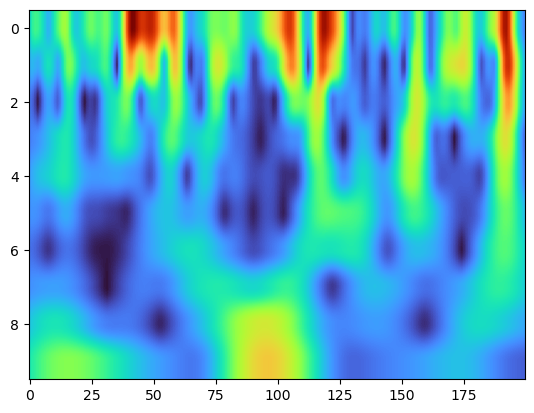

In [24]:
#load string
first_normal_np = np.array(first_normal.split()).reshape(10,200).astype(np.float)

plt.imshow(first_normal_np, aspect='auto', cmap='turbo')